In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# --- load + parse ---
BASE_DIR = 'D:/Desktop/mobility-seoul/'  # Change this to your base directory!

sdot_weather = pd.read_csv(os.path.join(BASE_DIR, 'Data/S-DoT_sensors/S-DoT_NATURE_20230724-20230826_en_preprocessed.csv'), header = 0)

sdot_weather["datetime"] = pd.to_datetime(sdot_weather["datetime"], errors="coerce", utc=True).dt.tz_convert("Asia/Seoul")
sdot_weather = sdot_weather.dropna(subset=["datetime","serial"])
sdot_weather = sdot_weather.sort_values(["serial","datetime"])

In [54]:

sdot_weather = sdot_weather.sort_values(["serial", "datetime"]).copy()

# datetime only where temperature is non-null; NaT otherwise
dt_if_valid = sdot_weather["datetime"].where(sdot_weather["temperature_mean_C"].notna())

# last valid datetime per station carried forward
last_valid_dt = dt_if_valid.groupby(sdot_weather["serial"]).ffill()

# minutes since last valid temperature for each row
sdot_weather["mins_since_last_valid_temp"] = (
    (sdot_weather["datetime"] - last_valid_dt).dt.total_seconds() / 60.0
)

# optional: round to whole minutes and keep NaNs (nullable int)
sdot_weather["mins_since_last_valid_temp"] = (
    sdot_weather["mins_since_last_valid_temp"].round().astype("Int64")
)

# quick check (shows serial, time, temp, computed minutes)
print(sdot_weather[["serial", "datetime", "temperature_mean_C", "mins_since_last_valid_temp"]].head(10))

            serial                  datetime  temperature_mean_C  \
1201   OC3CL200010 2023-09-25 01:08:04+09:00                19.9   
2045   OC3CL200010 2023-09-25 02:08:06+09:00                19.1   
3008   OC3CL200010 2023-09-25 03:08:05+09:00                18.2   
5234   OC3CL200010 2023-09-25 06:08:03+09:00                16.1   
6236   OC3CL200010 2023-09-25 07:08:03+09:00                16.0   
7232   OC3CL200010 2023-09-25 08:08:02+09:00                17.0   
8203   OC3CL200010 2023-09-25 09:08:04+09:00                19.4   
9221   OC3CL200010 2023-09-25 10:08:06+09:00                21.0   
10189  OC3CL200010 2023-09-25 11:08:04+09:00                22.6   
11194  OC3CL200010 2023-09-25 12:08:08+09:00                25.9   

       mins_since_last_valid_temp  
1201                            0  
2045                            0  
3008                            0  
5234                            0  
6236                            0  
7232                            0  

In [47]:
# --- 1) minutes since previous row for the same station (regardless of nulls) ---
sdot_weather["gap_min_any"] = sdot_weather.groupby("serial")["datetime"].diff().dt.total_seconds() / 60.0

# --- pick the feature columns you care about (means) ---
var_cols = [
    "temperature_mean_C",
    "humidity_mean_pc",
    "PM2.5_mean_microgm3",
    "PM10_mean_microgm3",
]
var_cols = [c for c in var_cols if c in sdot_weather.columns]  # keep only existing

# --- 2) per-feature minutes since previous NON-NULL value at the same station ---
for col in var_cols:
    # datetime only when this feature is non-null; else NaT
    dt_if_valid = sdot_weather["datetime"].where(sdot_weather[col].notna())

    # carry the last valid datetime forward within each station
    last_valid_dt = dt_if_valid.groupby(sdot_weather["serial"]).ffill()

    # difference to the last non-null datetime (NaN if none yet)
    diff_min = (sdot_weather["datetime"] - last_valid_dt).dt.total_seconds() / 60.0

    sdot_weather[f"gap_min_since_prev_nonnull__{col}"] = diff_min

# Optional: if you also want "since next non-null" (looking forward), you can bfill instead:
# next_valid_dt = dt_if_valid.groupby(sdot_weather["serial"]).bfill()
# sdot_weather[f"gap_min_until_next_nonnull__{col}"] = (next_valid_dt - sdot_weather["datetime"]).dt.total_seconds() / 60.0

# Quick peek
print(sdot_weather.filter(["serial","datetime","gap_min_any"] + [f"gap_min_since_prev_nonnull__{c}" for c in var_cols]).head(12))

            serial                  datetime  gap_min_any  \
1201   OC3CL200010 2023-09-25 01:08:04+09:00          NaN   
2045   OC3CL200010 2023-09-25 02:08:06+09:00    60.033333   
3008   OC3CL200010 2023-09-25 03:08:05+09:00    59.983333   
5234   OC3CL200010 2023-09-25 06:08:03+09:00   179.966667   
6236   OC3CL200010 2023-09-25 07:08:03+09:00    60.000000   
7232   OC3CL200010 2023-09-25 08:08:02+09:00    59.983333   
8203   OC3CL200010 2023-09-25 09:08:04+09:00    60.033333   
9221   OC3CL200010 2023-09-25 10:08:06+09:00    60.033333   
10189  OC3CL200010 2023-09-25 11:08:04+09:00    59.966667   
11194  OC3CL200010 2023-09-25 12:08:08+09:00    60.066667   
12124  OC3CL200010 2023-09-25 13:08:07+09:00    59.983333   
13058  OC3CL200010 2023-09-25 14:08:08+09:00    60.016667   

       gap_min_since_prev_nonnull__temperature_mean_C  \
1201                                              0.0   
2045                                              0.0   
3008                               

In [48]:
# --- compute gaps (minutes) between consecutive records per station ---
sdot_weather["gap_min"] = sdot_weather.groupby("serial")["datetime"].diff().dt.total_seconds() / 60.0

C:\Users\Michele\AppData\Local\Temp\ipykernel_12136\1096225062.py:26: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["time_bin"] = ((df["datetime"].view("int64") // 10**9) - t0) // bin_seconds


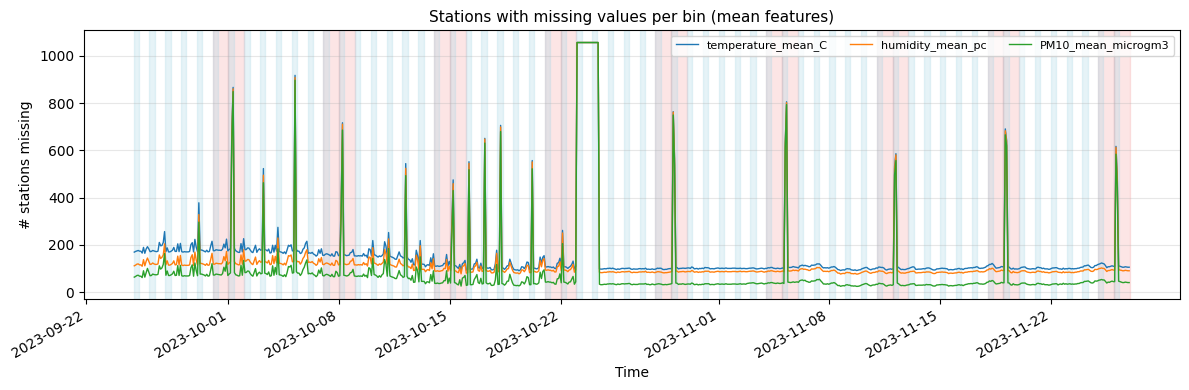

In [ ]:
# Binning: align to your movement bins
bin_seconds = 2 * 60 * 60  # 2 hours
start_time_dt = pd.Timestamp("2023-10-06 00:00:00", tz="Asia/Seoul")

var_cols = [
    "temperature_mean_C",
    "humidity_mean_pc",
    "PM10_mean_microgm3",
]

# ---------- Load & parse ----------
df = sdot_weather.copy()
if "serial" not in df.columns and "SerialNum" in df.columns:
    df = df.rename(columns={"SerialNum": "serial"})

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True).dt.tz_convert("Asia/Seoul")
df = df.dropna(subset=["serial", "datetime"]).sort_values(["serial", "datetime"]).reset_index(drop=True)

# Keep only existing features
var_cols = [c for c in var_cols if c in df.columns]
if not var_cols:
    raise ValueError("None of the requested columns are present in the file.")

# ---------- Bin assignment (midpoints for plotting) ----------
t0 = int(start_time_dt.timestamp())  # tz-aware already
df["time_bin"] = ((df["datetime"].view("int64") // 10**9) - t0) // bin_seconds
df["time_bin"] = df["time_bin"].astype(int)

# Bin midpoints (datetime) for nicer x-axis + weekend shading
bin_index = np.arange(df["time_bin"].min(), df["time_bin"].max() + 1)
bin_mid_ts = start_time_dt + pd.to_timedelta((bin_index + 0.5) * bin_seconds, unit="s")
bin_mid_df = pd.DataFrame({"time_bin": bin_index, "bin_time": bin_mid_ts})

# ---------- Aggregate per (station, bin) then count NaNs per feature ----------
agg = (df.groupby(["serial", "time_bin"], as_index=False)[var_cols]
         .mean(numeric_only=True))

n_stations_total = df["serial"].nunique()

# Build tidy frame: per feature + bin -> missing count
rows = []
for col in var_cols:
    v = (agg[["time_bin", col]]
         .assign(is_valid=lambda x: x[col].notna())
         .groupby("time_bin")["is_valid"].sum())
    v = v.reindex(bin_index, fill_value=0)
    missing = n_stations_total - v
    rows.append(pd.DataFrame({
        "feature": col,
        "time_bin": bin_index,
        "missing_stations": missing.values.astype(int),
    }))

missing_df = pd.concat(rows, ignore_index=True).merge(bin_mid_df, on="time_bin", how="left")

# ---------- Plot with weekend shading ----------
fig, ax = plt.subplots(figsize=(12, 4))

# Weekend shading: shade full days where weekday is Sat(5) or Sun(6)
# Build day ranges using the bin midpoints
days = pd.to_datetime(missing_df["bin_time"].dt.floor("D").unique())
for day in days:
    if day.weekday() >= 5:  # 5=Sat, 6=Sun
        ax.axvspan(day, day + pd.Timedelta(days=1), color="lightcoral", alpha=0.2, zorder=0)

for day in days:
    start = day + pd.Timedelta(hours=0)
    end   = day + pd.Timedelta(hours=8)  # cover the 23:00–24:00 hour
    ax.axvspan(start, end, color="lightblue", alpha=0.3, zorder=0.1)

# Plot one line per feature (missing stations over time)
for feat in var_cols:
    sub = missing_df[missing_df["feature"] == feat]
    ax.plot(sub["bin_time"], sub["missing_stations"], label=feat, linewidth=1)

ax.set_title("Stations with missing values per bin (mean features)", fontsize=11)
ax.set_xlabel("Time")
ax.set_ylabel("# stations missing")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(ncol=min(len(var_cols), 4), fontsize=8)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

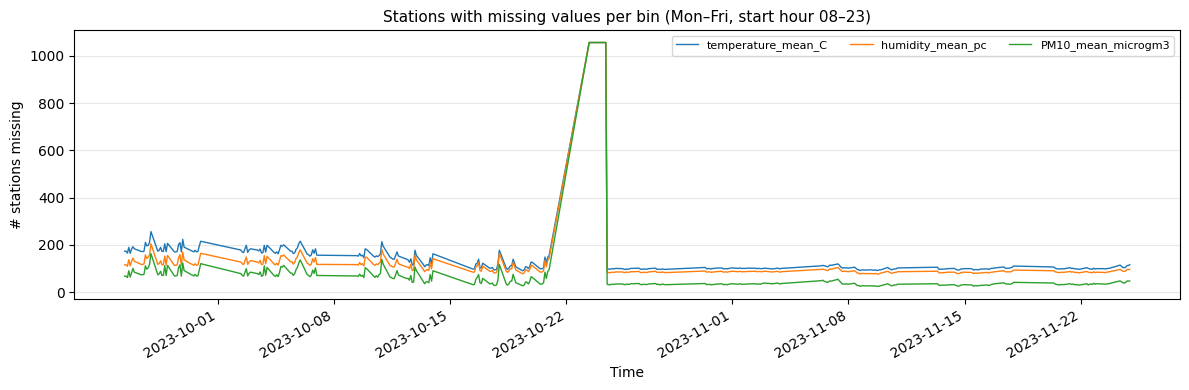

In [64]:
# --- compute bin START timestamp for filtering (not the midpoint) ---
missing_df["bin_start"] = missing_df["time_bin"].apply(
    lambda tb: start_time_dt + pd.to_timedelta(tb * bin_seconds, unit="s")
)

# --- filter: weekdays only (Mon=0..Fri=4) and hours 08..23 inclusive ---
is_weekday = missing_df["bin_start"].dt.weekday <= 4
start_hour = missing_df["bin_start"].dt.hour
in_hours   = start_hour.between(8, 23)  # inclusive
mask = is_weekday & in_hours

missing_df_filt = missing_df[mask].copy()

# --- plot (no weekend/early-hours bins present) ---
fig, ax = plt.subplots(figsize=(12, 4))
for feat in var_cols:
    sub = missing_df_filt[missing_df_filt["feature"] == feat]
    ax.plot(sub["bin_time"], sub["missing_stations"], label=feat, linewidth=1)

ax.set_title("Stations with missing values per bin (Mon–Fri, start hour 08–23)", fontsize=11)
ax.set_xlabel("Time")
ax.set_ylabel("# stations missing")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(ncol=min(len(var_cols), 4), fontsize=8)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [57]:
# ---------- Print bins with 0 valid and >400 invalid (per feature) ----------
threshold_invalid = 400  # change if you like

for feat in var_cols:
    sub = missing_df[missing_df["feature"] == feat].copy()
    sub["valid_stations"] = n_stations_total - sub["missing_stations"]

    zero_valid = sub[sub["valid_stations"] == 0][["time_bin", "bin_time", "missing_stations"]]
    many_invalid = sub[sub["missing_stations"] > threshold_invalid][
        ["time_bin", "bin_time", "missing_stations", "valid_stations"]
    ]

    print(f"\n=== {feat} — bins with 0 valid stations ({len(zero_valid)}) ===")
    if zero_valid.empty:
        print("None")
    else:
        print(zero_valid.to_string(index=False))

    print(f"\n=== {feat} — bins with > {threshold_invalid} invalid stations ({len(many_invalid)}) ===")
    if many_invalid.empty:
        print("None")
    else:
        print(many_invalid.to_string(index=False))


=== temperature_mean_C — bins with 0 valid stations (17) ===
 time_bin                  bin_time  missing_stations
      204 2023-10-23 01:00:00+09:00              1057
      205 2023-10-23 03:00:00+09:00              1057
      206 2023-10-23 05:00:00+09:00              1057
      207 2023-10-23 07:00:00+09:00              1057
      208 2023-10-23 09:00:00+09:00              1057
      209 2023-10-23 11:00:00+09:00              1057
      210 2023-10-23 13:00:00+09:00              1057
      211 2023-10-23 15:00:00+09:00              1057
      212 2023-10-23 17:00:00+09:00              1057
      213 2023-10-23 19:00:00+09:00              1057
      214 2023-10-23 21:00:00+09:00              1057
      215 2023-10-23 23:00:00+09:00              1057
      216 2023-10-24 01:00:00+09:00              1057
      217 2023-10-24 03:00:00+09:00              1057
      218 2023-10-24 05:00:00+09:00              1057
      219 2023-10-24 07:00:00+09:00              1057
      220 2023-10-24

In [49]:
# choose features (means)
interval = 2 * 60 * 60  # 2 hour

start_time_dt = pd.Timestamp("2023-10-06 00:00:00", tz="Asia/Seoul")

var_cols = [
    "temperature_mean_C",
    "humidity_mean_pc",
    "PM2.5_mean_microgm3",
    "PM10_mean_microgm3",
]
# keep only existing columns
var_cols = [c for c in var_cols if c in sdot_weather.columns]

# --- align to your binning ---
try:
    start_time_dt  # from your main script
    bin_seconds = interval
    print(f"Aligning to {start_time_dt} with bin size {bin_seconds} seconds")
except NameError:
    # fallback: align to midnight of first day in data
    start_time_dt = sdot_weather["datetime"].dt.floor("D").min()
    bin_seconds = 2 * 60 * 60  # default 2h if not set; change as needed

t0 = int((start_time_dt if start_time_dt.tzinfo else start_time_dt.tz_localize("Asia/Seoul")).timestamp())
sdot_weather["time_bin"] = ((sdot_weather["datetime"].view("int64") // 10**9) - t0) // bin_seconds
sdot_weather["time_bin"] = sdot_weather["time_bin"].astype(int)

# --- aggregate to *bin* per station: take mean within each (serial, time_bin) ---
agg = (sdot_weather.groupby(["serial","time_bin"], as_index=False)[var_cols]
         .mean(numeric_only=True))

n_stations_total = sdot_weather["serial"].nunique()
all_bins = np.arange(agg["time_bin"].min(), agg["time_bin"].max()+1)

# build a tidy DataFrame with, for each feature and bin:
#   - valid_stations: #stations with non-null value
#   - missing_stations: n_total - valid
rows = []
for col in var_cols:
    valid_counts = (agg[["time_bin", col]]
                    .assign(valid=lambda x: x[col].notna())
                    .groupby("time_bin")["valid"].sum())
    valid_counts = valid_counts.reindex(all_bins, fill_value=0)
    missing_counts = n_stations_total - valid_counts
    tmp = pd.DataFrame({
        "time_bin": all_bins,
        "feature": col,
        "valid_stations": valid_counts.values.astype(int),
        "missing_stations": missing_counts.values.astype(int),
    })
    rows.append(tmp)

bin_missing = pd.concat(rows, ignore_index=True)

# quick summary table per feature
summary = (bin_missing.groupby("feature")
           .agg(bins=("time_bin","nunique"),
                stations_total=("missing_stations", lambda s: n_stations_total),
                mean_missing=("missing_stations","mean"),
                median_missing=("missing_stations","median"),
                pct_bins_with_missing=("missing_stations", lambda s: 100*(s>0).mean()),
                min_valid=("valid_stations","min"),
                max_valid=("valid_stations","max"))
           .sort_values("pct_bins_with_missing", ascending=False))
print("\nMissing-stations per bin (summary):")
print(summary)

Aligning to 2023-10-06 00:00:00+09:00 with bin size 7200 seconds


C:\Users\Michele\AppData\Local\Temp\ipykernel_12136\3158586746.py:26: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  sdot_weather["time_bin"] = ((sdot_weather["datetime"].view("int64") // 10**9) - t0) // bin_seconds



Missing-stations per bin (summary):
                     bins  stations_total  mean_missing  median_missing  \
feature                                                                   
PM10_mean_microgm3    756            1057     89.189153            39.0   
PM2.5_mean_microgm3   756            1057     88.800265            38.0   
humidity_mean_pc      756            1057    137.419312            90.0   
temperature_mean_C    756            1057    160.441799           106.0   

                     pct_bins_with_missing  min_valid  max_valid  
feature                                                           
PM10_mean_microgm3                   100.0          0       1033  
PM2.5_mean_microgm3                  100.0          0       1033  
humidity_mean_pc                     100.0          0        981  
temperature_mean_C                   100.0          0        967  


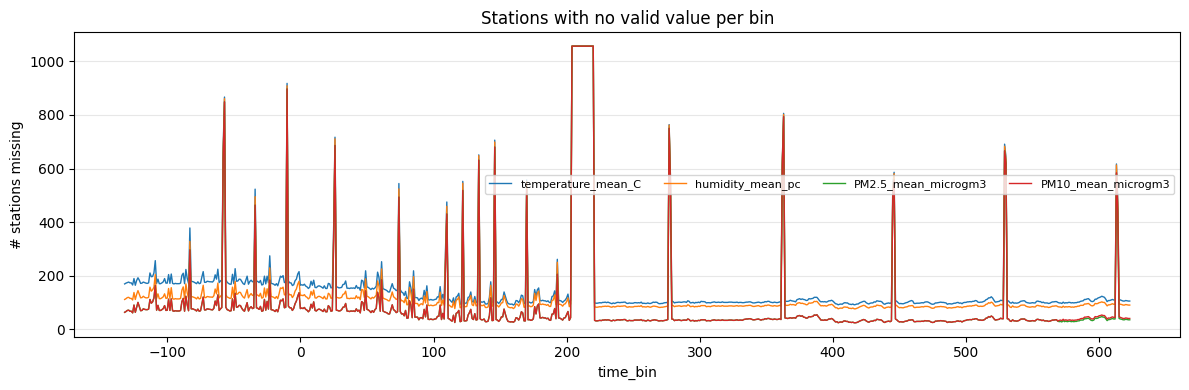

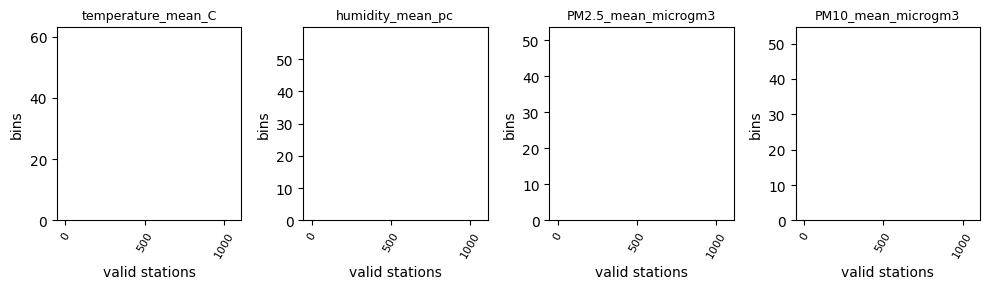


% bins estimated to require per-bin triangulation (by feature):
feature
PM10_mean_microgm3     100.0
PM2.5_mean_microgm3    100.0
humidity_mean_pc       100.0
temperature_mean_C     100.0
Name: % bins requiring per-bin triangulation, dtype: float64


In [50]:
# plots: missing stations over time for each feature
plt.figure(figsize=(12,4))
for col in var_cols:
    sub = bin_missing[bin_missing["feature"]==col]
    plt.plot(sub["time_bin"], sub["missing_stations"], label=col, linewidth=1)
plt.xlabel("time_bin")
plt.ylabel("# stations missing")
plt.title("Stations with no valid value per bin")
plt.legend(ncol=min(len(var_cols),4), fontsize=8)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

# distribution of valid station counts (per feature)
plt.figure(figsize=(10,3))
for i, col in enumerate(var_cols, 1):
    sub = bin_missing[bin_missing["feature"]==col]
    plt.subplot(1, len(var_cols), i)
    plt.hist(sub["valid_stations"], bins=np.arange(0, n_stations_total+2)-0.5, edgecolor="white")
    plt.title(col, fontsize=9); plt.xlabel("valid stations"); plt.ylabel("bins")
    plt.xticks(rotation=60, fontsize=8)
plt.tight_layout(); plt.show()

# estimate "rebuilds" per feature: bins where at least one station is missing
rebuild_estimate = (bin_missing.assign(rebuild=lambda r: r["missing_stations"] > 0)
                    .groupby("feature")["rebuild"]
                    .mean().mul(100).rename("% bins requiring per-bin triangulation"))
print("\n% bins estimated to require per-bin triangulation (by feature):")
print(rebuild_estimate)

         serial                  datetime  gap_min_any  \
0   OC3CL200010 2023-09-25 01:08:04+09:00          NaN   
1   OC3CL200010 2023-09-25 02:08:06+09:00    60.033333   
2   OC3CL200010 2023-09-25 03:08:05+09:00    59.983333   
3   OC3CL200010 2023-09-25 06:08:03+09:00   179.966667   
4   OC3CL200010 2023-09-25 07:08:03+09:00    60.000000   
5   OC3CL200010 2023-09-25 08:08:02+09:00    59.983333   
6   OC3CL200010 2023-09-25 09:08:04+09:00    60.033333   
7   OC3CL200010 2023-09-25 10:08:06+09:00    60.033333   
8   OC3CL200010 2023-09-25 11:08:04+09:00    59.966667   
9   OC3CL200010 2023-09-25 12:08:08+09:00    60.066667   
10  OC3CL200010 2023-09-25 13:08:07+09:00    59.983333   
11  OC3CL200010 2023-09-25 14:08:08+09:00    60.016667   

    gap_min_since_prev_nonnull__temperature_mean_C  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                            

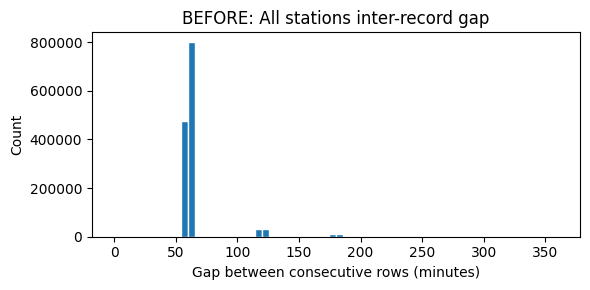

C:\Users\Michele\AppData\Local\Temp\ipykernel_12136\45443718.py:133: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["time_bin"] = ((df[time_col].view("int64") // 10**9) - t0) // bin_seconds



BEFORE — Missing-stations per bin (summary):
                     bins  stations_total  mean_missing  median_missing  \
feature                                                                   
PM10_mean_microgm3    756            1057     89.189153            39.0   
PM2.5_mean_microgm3   756            1057     88.800265            38.0   
humidity_mean_pc      756            1057    137.419312            90.0   
temperature_mean_C    756            1057    160.441799           106.0   

                     pct_bins_with_missing  min_valid  max_valid  
feature                                                           
PM10_mean_microgm3                   100.0          0       1033  
PM2.5_mean_microgm3                  100.0          0       1033  
humidity_mean_pc                     100.0          0        981  
temperature_mean_C                   100.0          0        967  


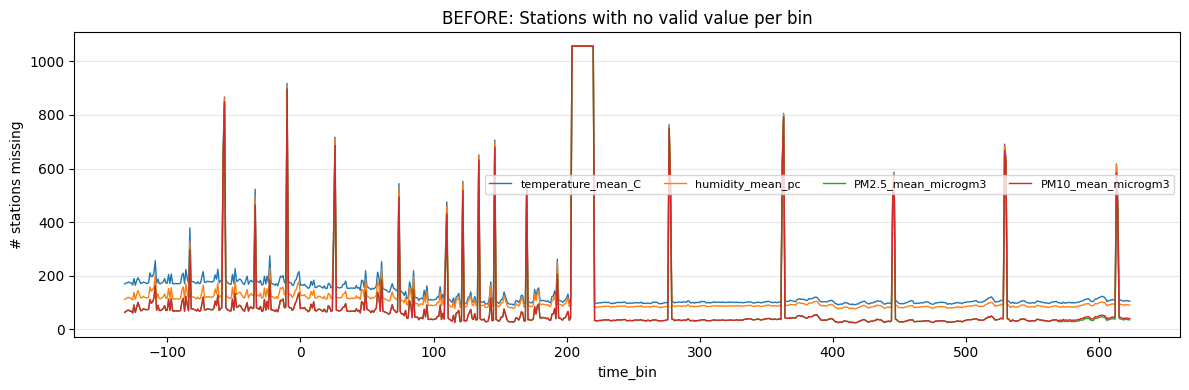

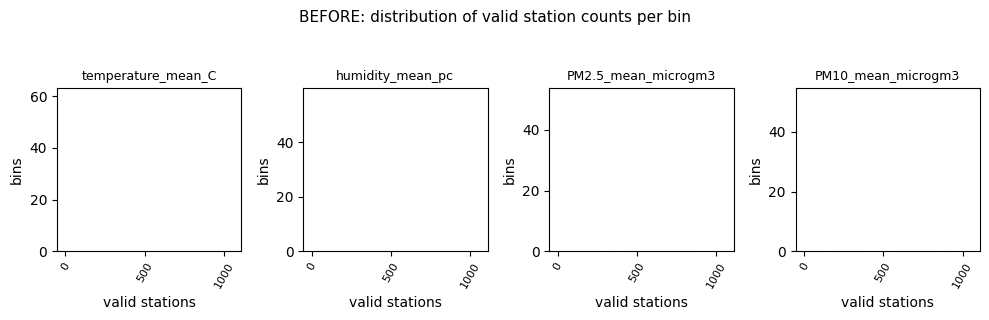


Imputation rates (≤90 min):
  temperature_mean_C: 0.0% of rows were imputed
  humidity_mean_pc: 0.0% of rows were imputed
  PM2.5_mean_microgm3: 0.0% of rows were imputed
  PM10_mean_microgm3: 0.0% of rows were imputed


C:\Users\Michele\AppData\Local\Temp\ipykernel_12136\45443718.py:133: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["time_bin"] = ((df[time_col].view("int64") // 10**9) - t0) // bin_seconds



AFTER (≤90 min pass) — Missing-stations per bin (summary):
                     bins  stations_total  mean_missing  median_missing  \
PM10_mean_microgm3    756            1057     89.177249            39.0   
PM2.5_mean_microgm3   756            1057     88.797619            38.0   
humidity_mean_pc      756            1057    137.375661            90.0   
temperature_mean_C    756            1057    160.300265           106.0   

                     pct_bins_with_missing  min_valid  max_valid  
PM10_mean_microgm3                   100.0          0       1033  
PM2.5_mean_microgm3                  100.0          0       1033  
humidity_mean_pc                     100.0          0        981  
temperature_mean_C                   100.0          0        967  


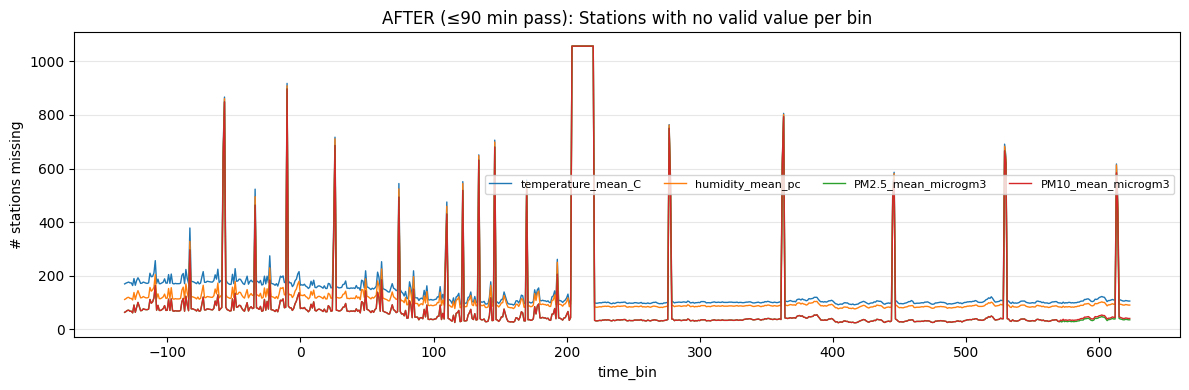

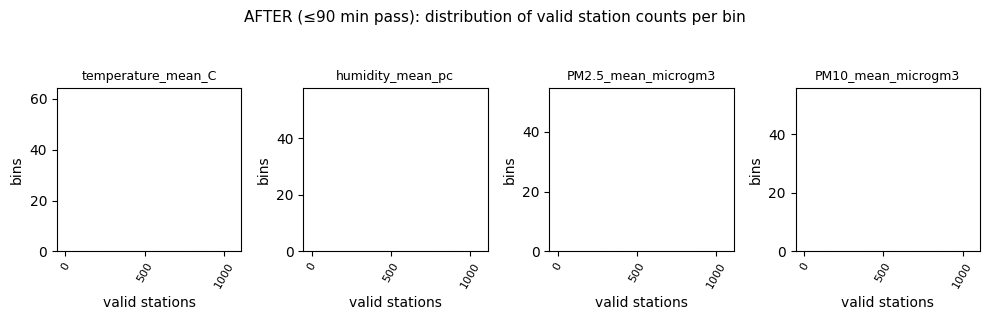

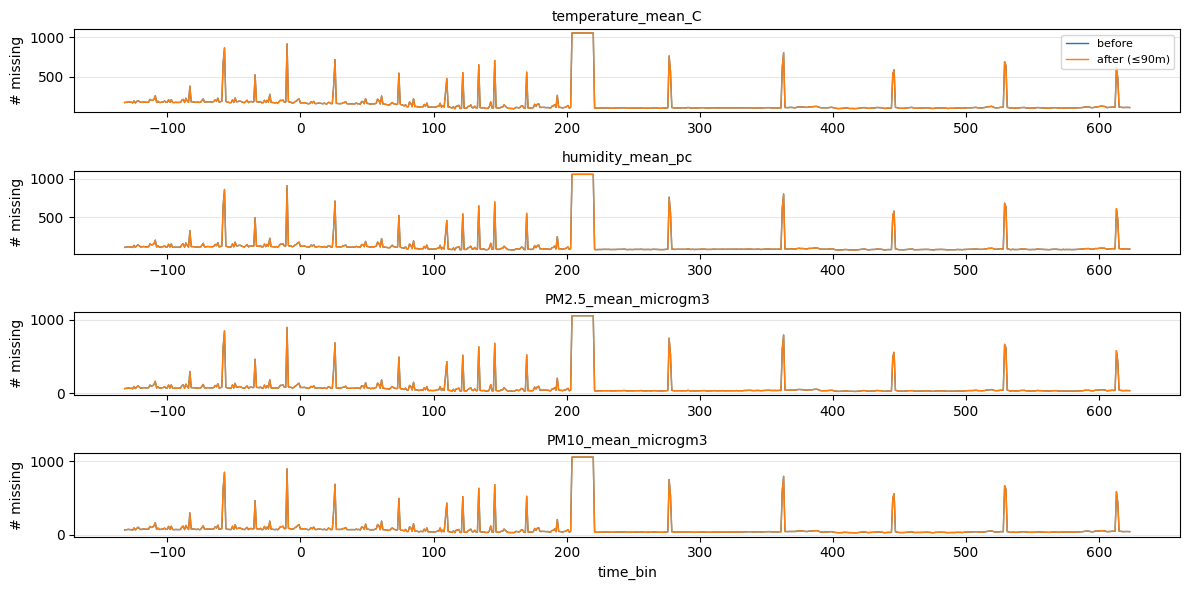